In [1]:
from transformers import CLIPModel, CLIPProcessor, CLIPTokenizer
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from model import CLIPBackbone, AttentionHead

In [2]:
clip = transformers.CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
def params(m): return sum(p.numel() for p in m.parameters())

In [3]:
print("CLIP", params(clip))

CLIP 151277313


In [4]:
print("CLIP: ", clip)

CLIP:  CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,),

In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("nlphuji/flickr30k")  # huggingface dataset

In [6]:
# Check available splits and keys
print("Available splits:", dataset.keys())
split_name = "test"
test_data = dataset[split_name]
print("Sample keys:", test_data[0].keys())

Available splits: dict_keys(['test'])
Sample keys: dict_keys(['image', 'caption', 'sentids', 'split', 'img_id', 'filename'])


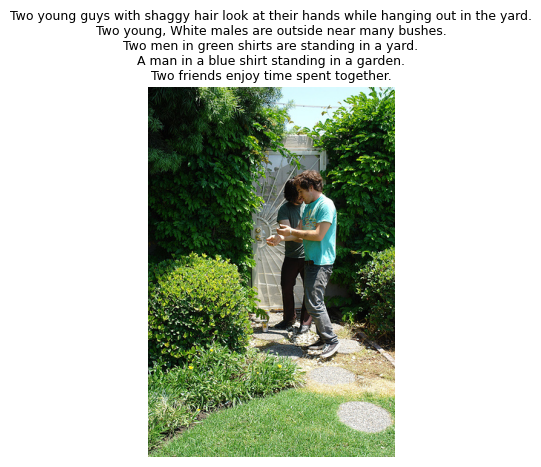

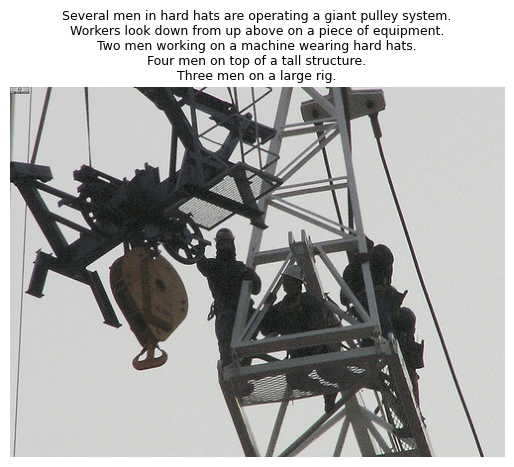

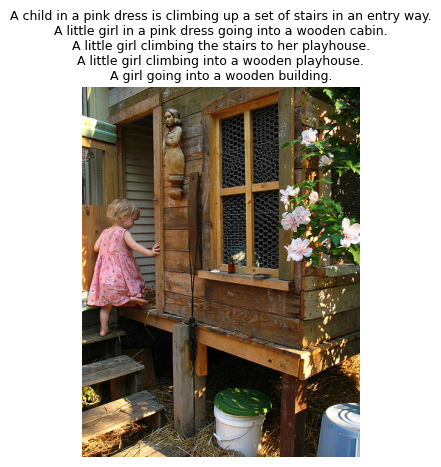

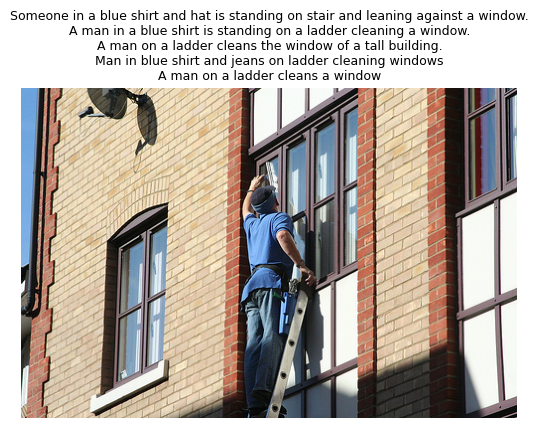

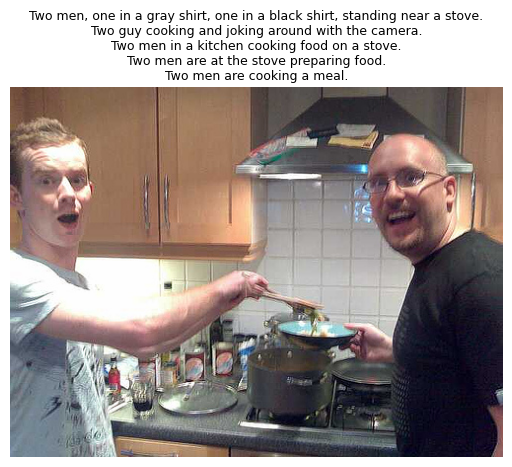

In [7]:

# Visualize first N samples
N = 5
for i in range(N):
    sample = test_data[i]
    image = sample['image']
    captions = sample['caption']

    # Plot image
    plt.imshow(image)
    plt.axis('off')
    plt.title("\n".join(captions), fontsize=9)
    plt.show()

In [8]:
# Load CLIP model and processor
# CLIPProcessor handles tokenizing text and preprocessing images into tensors
# CLIPModel computes the embeddings for the inputs
from transformers import CLIPModel, CLIPTokenizer


class CLIPBackbone(nn.Module):
    # Frozen CLIP, exposes vision and text embeddings only."""
    def __init__(self, model_name: str = "openai/clip-vit-base-patch32", image_proj_dim: int = 512, text_proj_dim: int = 512):
        super().__init__()
        # loads pretrained CLIP model from Hugging Face
        self.clip = CLIPModel.from_pretrained(model_name)
        # loads the tokenizer from CLIP which converts text to input Ids
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        # sets the CLIP model to evaluation mode - disables  dropout layer norm updates
        self.clip.eval()
        for p in self.clip.parameters():
            # Freezes all the weights in CLIP model - no gradients will be computed during backpropagation
            p.requires_grad = False
        # Image projection layer
        image_hidden_dim = self.clip.vision_model.config.\
            hidden_size
        self.image_proj = nn.Linear(image_hidden_dim, image_proj_dim)

        # Text projection layer
        text_hidden_dim = self.clip.text_model.config.hidden_size
        self.text_proj = nn.Linear(text_hidden_dim, text_proj_dim)

    @torch.no_grad()  # disables autograd for memory+speed
    def encode_image(self, pixel_values: torch.FloatTensor) -> torch.FloatTensor:
        # (B, L_v, D_v)
        # passes the preprocessed image into CLIP's vision encode and returns per-patch embeddings of shape [B, 50, 68]
        out = self.clip.vision_model(pixel_values).last_hidden_state
        # returns the hidden states (patch level embeddings) without projecting them
        return out

    @torch.no_grad()  # disables autograd for memory+speed
    def embedded_text(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        # (B, L_v, D_v)
        # equivalent to nn.Embedding(..) aka embedding layer from CLIP
        # access embedding submodule of clip text encoder
        emb = self.clip.text_model.embeddings
        # applies the token embedding layer to input_ids and returns [B, seq_len, 512]
        out = emb(input_ids=input_ids)
        # Print ("Clip text embedding dim:", ot.shaoe[-1])
        return out  # returns raw token embeddings - no posotion embeddings or encoding layers

In [ ]:
import torchvision.transforms as transforms

# Load CLIP model and tokenizer directly
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Initialize the CLIP Backbone
backbone = CLIPBackbone()
# Create a transform to resize and convert to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),  # Convert to tensor
    # Normalize (optional, but recommended)
    # Normalize (optional, but recommended)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Take an example from the dataset
example = dataset['test'][0]
# Process image manually
image = example['image']
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Process text
caption = example['caption']
text_inputs = tokenizer(caption, return_tensors="pt",
                        padding=True, truncation=True)

# Encode image using CLIPBackbone
image_embeddings = backbone.encode_image(image_tensor)
print("Raw Image Embeddings Shape:", image_embeddings.shape)

# Project image embeddings
image_embeddings_proj = backbone.image_proj(image_embeddings)
print("Projected Image Embeddings Shape:", image_embeddings_proj.shape)

# Embed text using CLIPBackbone
text_embeddings = backbone.embedded_text(text_inputs.input_ids)
print("Raw Text Embeddings Shape:", text_embeddings.shape)

# Project text embeddings
text_embeddings_proj = backbone.text_proj(text_embeddings)
print("Projected Text Embeddings Shape:", text_embeddings_proj.shape)

# Print caption
print("\nCaption:", caption)

# Combine embeddings
combined_embeddings = torch.cat(
    [image_embeddings_proj, text_embeddings_proj], dim=1)
print("Combined Embeddings Shape:", combined_embeddings.shape)

# Test Attention Head
max_seq_len = combined_embeddings.shape[1]
attn_head = AttentionHead(
    embed_dim=combined_embeddings.shape[-1],
    head_size=64,
    max_seq_len=max_seq_len
)

# Apply attention head
out = attn_head(combined_embeddings, image_len=image_embeddings_proj.shape[1])
print("Attention Head Output Shape:", out.shape)

ValueError: Input image size (500*333) doesn't match model (224*224).